# Importing required modules

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from scipy.io import wavfile
from scipy import signal

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data preparation 

In [2]:
#Declaring the locations of dataset
Ravdess = "audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(Ravdess)

#Extracting the data 
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
data_path.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
data_path.head()


,Emotions,Path
0,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
1,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
2,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
3,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
4,calm,audio_speech_actors_01-24/Actor_01/03-01-02-01...


# Data interpretation

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.arange(len(data)) / sr, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    f, t, Sxx = signal.spectrogram(data, sr)
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

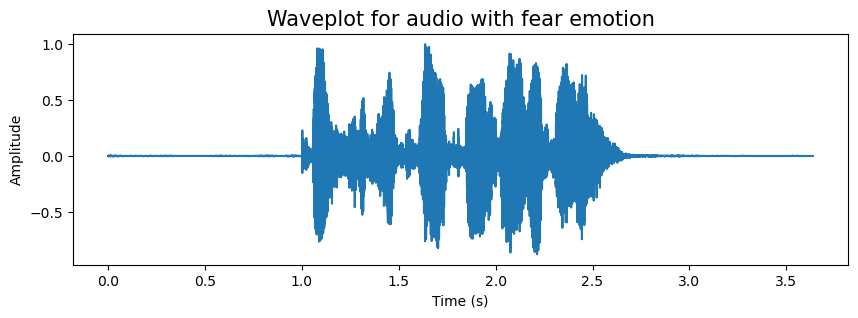

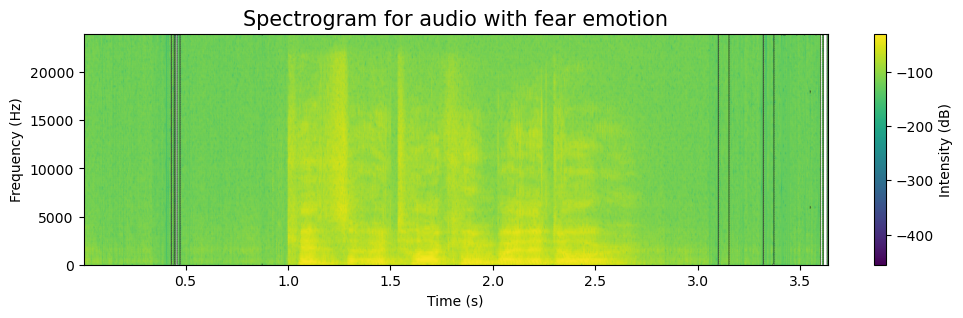

In [5]:
#Wave plot for the fear emotion
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]

sampling_rate, data = wavfile.read(path)

data = data / np.max(np.abs(data))

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

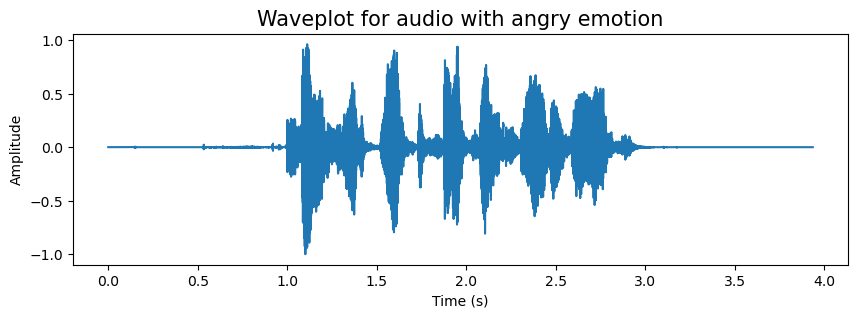

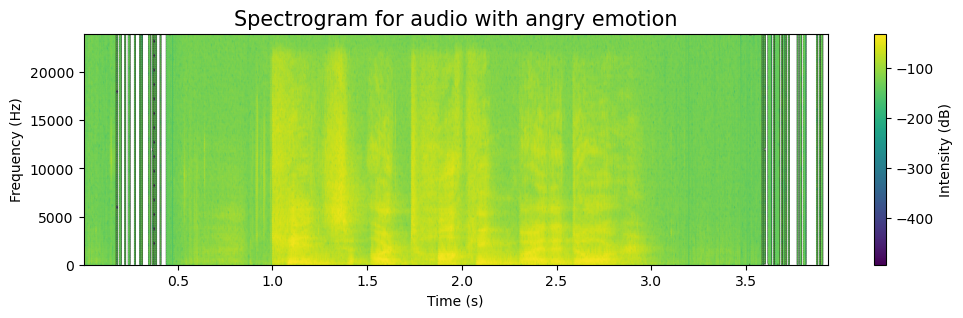

In [6]:
#Waveplot for the angry emotion
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]

sampling_rate, data = wavfile.read(path)

data = data / np.max(np.abs(data))

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Data Augmentation

In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)


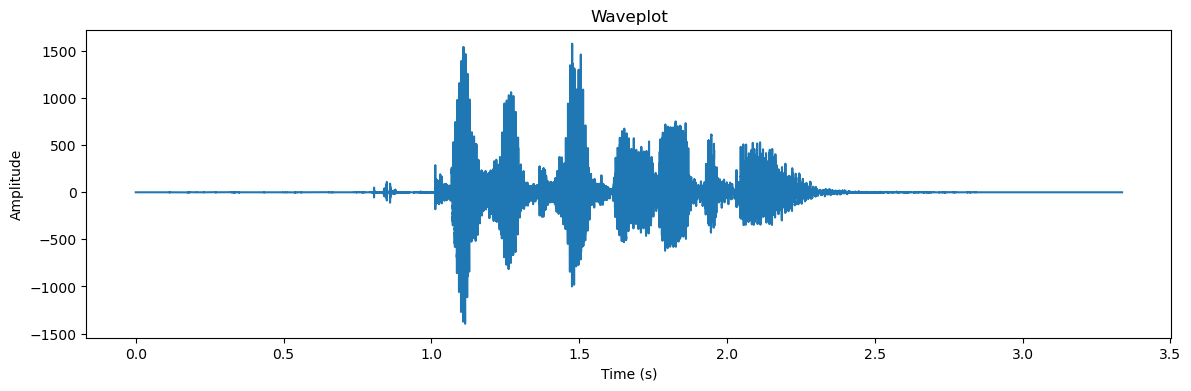

In [8]:
#Original data
path = np.array(data_path.Path)[1]
sample_rate, data = wavfile.read(path)

plt.figure(figsize=(14, 4))
plt.title('Waveplot')
plt.plot(np.arange(len(data)) / sample_rate, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(path)

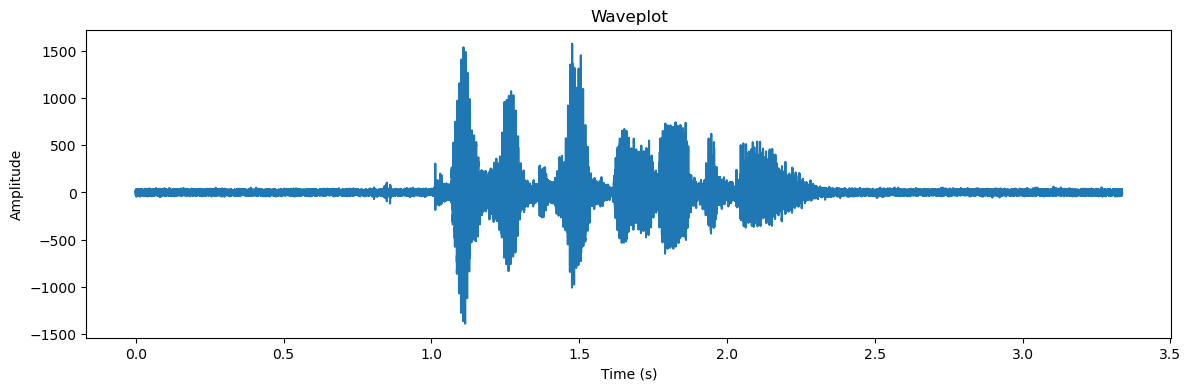

In [9]:
#Data with noise
x = noise(data)

plt.figure(figsize=(14, 4))
plt.title('Waveplot')
plt.plot(np.arange(len(data)) / sample_rate, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

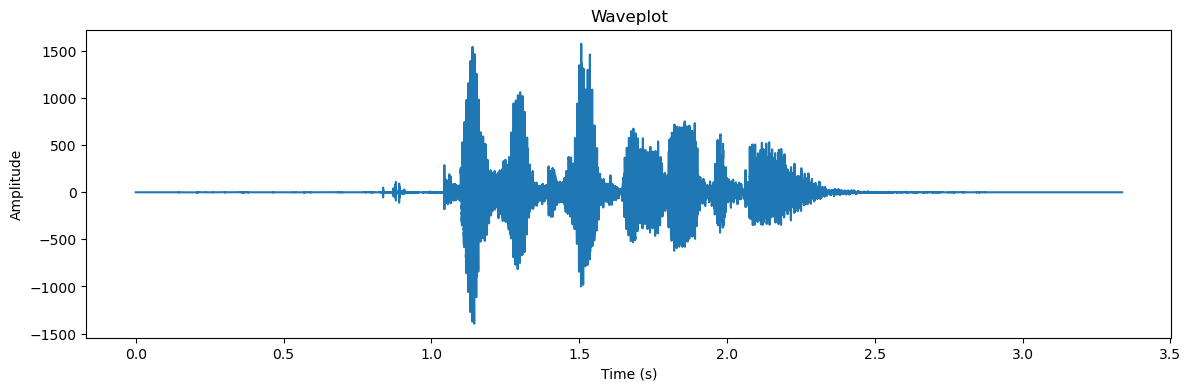

In [10]:
#Data after shifting
x = shift(data)

plt.figure(figsize=(14, 4))
plt.title('Waveplot')
plt.plot(np.arange(len(data)) / sample_rate, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise and shift
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    data_shift = shift(data)
    res3 = extract_features(data_shift)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [12]:
#Applying data augmentation to entire data and extracting features
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [13]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

# Data preprocessing

In [14]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.730855,0.695406,0.748813,0.727905,0.680875,0.694757,0.700008,0.681208,0.722061,...,0.000002,0.000002,0.000002,0.000001,9.996285e-07,0.000003,0.000004,0.000003,6.234665e-07,neutral
1,0.334690,0.785100,0.761834,0.819749,0.817799,0.768108,0.758306,0.754807,0.700062,0.708827,...,0.000067,0.000064,0.000063,0.000064,6.511014e-05,0.000062,0.000067,0.000065,6.410437e-05,neutral
2,0.321036,0.726066,0.703527,0.749135,0.721662,0.676768,0.698331,0.692847,0.675416,0.725898,...,0.000002,0.000002,0.000002,0.000001,9.996302e-07,0.000003,0.000004,0.000003,6.234670e-07,neutral
3,0.293566,0.727275,0.692217,0.704081,0.708575,0.646564,0.644026,0.677236,0.629682,0.661485,...,0.000003,0.000003,0.000003,0.000003,3.223131e-06,0.000005,0.000005,0.000004,5.938138e-07,neutral
4,0.337131,0.764729,0.768337,0.789814,0.793798,0.747395,0.734429,0.746447,0.681526,0.682197,...,0.000076,0.000079,0.000079,0.000082,8.517983e-05,0.000081,0.000078,0.000078,7.982337e-05,neutral


In [15]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [16]:
#Applying One hot encoding to the data
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
#Splitting the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [18]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [19]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [20]:
#Creating model
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

# Model Training 

In [21]:
# Callback to reduce learning rate when a monitored metric has stopped improving
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)

# Callback to save the best model based on validation loss
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Fit the model with callbacks
history = model.fit(x_train, y_train, 
                    batch_size=64, 
                    epochs=60, 
                    validation_data=(x_test, y_test), 
                    callbacks=[rlrp, checkpoint])


Epoch 1/60
51/51 [==============================] - ETA: 0s - loss: 1.9624 - accuracy: 0.2065
Epoch 1: val_loss improved from inf to 1.88026, saving model to best_model_weights.h5
51/51 [==============================] - 8s 118ms/step - loss: 1.9624 - accuracy: 0.2065 - val_loss: 1.8803 - val_accuracy: 0.3111 - lr: 0.0010
Epoch 2/60
51/51 [==============================] - ETA: 0s - loss: 1.8714 - accuracy: 0.2580
Epoch 2: val_loss improved from 1.88026 to 1.72677, saving model to best_model_weights.h5
51/51 [==============================] - 8s 158ms/step - loss: 1.8714 - accuracy: 0.2580 - val_loss: 1.7268 - val_accuracy: 0.3074 - lr: 0.0010
Epoch 3/60
51/51 [==============================] - ETA: 0s - loss: 1.7962 - accuracy: 0.2988
Epoch 3: val_loss improved from 1.72677 to 1.63271, saving model to best_model_weights.h5
51/51 [==============================] - 8s 154ms/step - loss: 1.7962 - accuracy: 0.2988 - val_loss: 1.6327 - val_accuracy: 0.4037 - lr: 0.0010
Epoch 4/60
51/51 [==

Epoch 27/60
51/51 [==============================] - ETA: 0s - loss: 0.7779 - accuracy: 0.7111
Epoch 27: val_loss improved from 0.82487 to 0.82201, saving model to best_model_weights.h5
51/51 [==============================] - 8s 155ms/step - loss: 0.7779 - accuracy: 0.7111 - val_loss: 0.8220 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 28/60
51/51 [==============================] - ETA: 0s - loss: 0.7680 - accuracy: 0.7176
Epoch 28: val_loss improved from 0.82201 to 0.79169, saving model to best_model_weights.h5
51/51 [==============================] - 7s 144ms/step - loss: 0.7680 - accuracy: 0.7176 - val_loss: 0.7917 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 29/60
51/51 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.7179
Epoch 29: val_loss improved from 0.79169 to 0.73979, saving model to best_model_weights.h5
51/51 [==============================] - 7s 147ms/step - loss: 0.7347 - accuracy: 0.7179 - val_loss: 0.7398 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 30/6

51/51 [==============================] - 8s 156ms/step - loss: 0.2590 - accuracy: 0.9093 - val_loss: 0.5856 - val_accuracy: 0.8519 - lr: 6.4000e-05
Epoch 54/60
51/51 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9093
Epoch 54: val_loss did not improve from 0.57200
51/51 [==============================] - 11s 219ms/step - loss: 0.2590 - accuracy: 0.9093 - val_loss: 0.5912 - val_accuracy: 0.8556 - lr: 6.4000e-05
Epoch 55/60
51/51 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8966
Epoch 55: ReduceLROnPlateau reducing learning rate to 2.560000284574926e-05.

Epoch 55: val_loss did not improve from 0.57200
51/51 [==============================] - 14s 274ms/step - loss: 0.2753 - accuracy: 0.8966 - val_loss: 0.5903 - val_accuracy: 0.8519 - lr: 6.4000e-05
Epoch 56/60
51/51 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.9068
Epoch 56: val_loss did not improve from 0.57200
51/51 [==============================] - 14s 27

# Testing the model on test data

In [22]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

34/34 [==============================] - 2s 43ms/step - loss: 0.5882 - accuracy: 0.8556
Accuracy of our model on test data :  85.5555534362793 %


# Accuracy and Loss plots

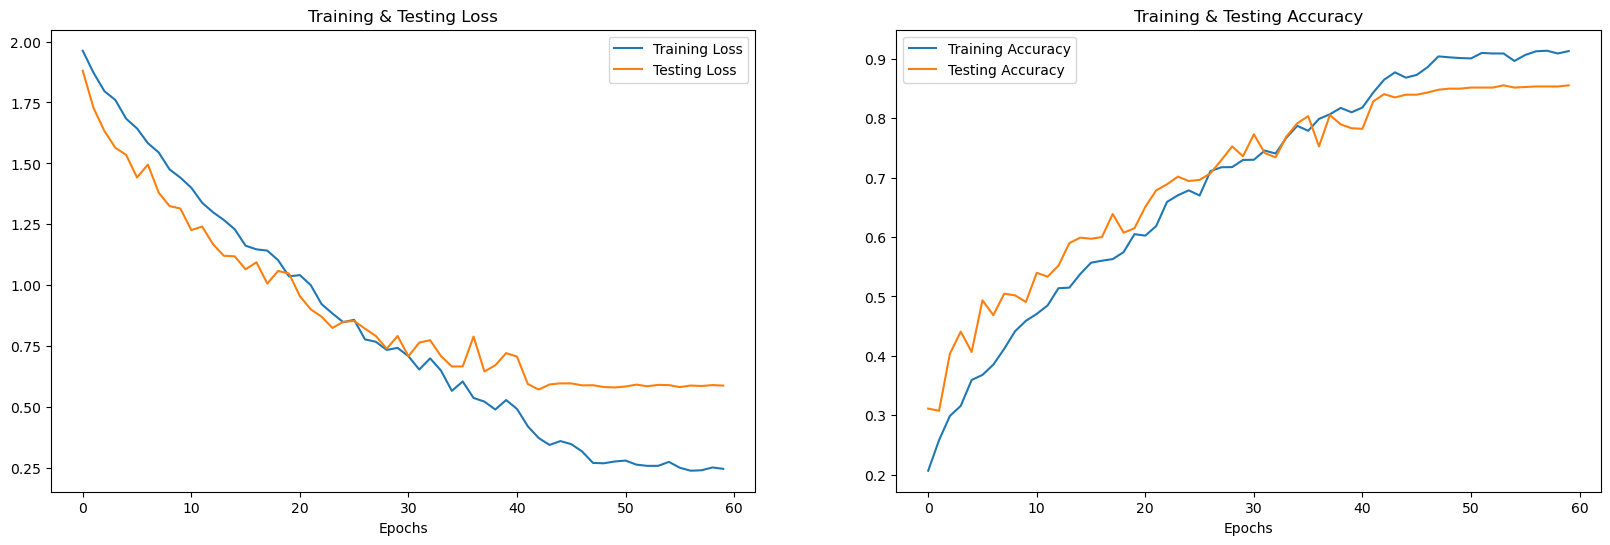

In [24]:
epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Evaluation metrics

In [25]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 2s 41ms/step


In [26]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,calm,calm
4,happy,angry
5,surprise,surprise
6,fear,fear
7,happy,happy
8,fear,fear
9,happy,sad


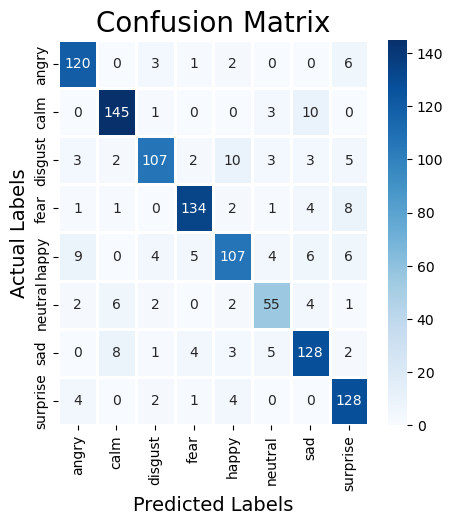

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (5, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.86      0.91      0.89       132
        calm       0.90      0.91      0.90       159
     disgust       0.89      0.79      0.84       135
        fear       0.91      0.89      0.90       151
       happy       0.82      0.76      0.79       141
     neutral       0.77      0.76      0.77        72
         sad       0.83      0.85      0.84       151
    surprise       0.82      0.92      0.87       139

    accuracy                           0.86      1080
   macro avg       0.85      0.85      0.85      1080
weighted avg       0.86      0.86      0.85      1080



# Predicting on a sample data

In [6]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from scipy.io import wavfile
from scipy import signal

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

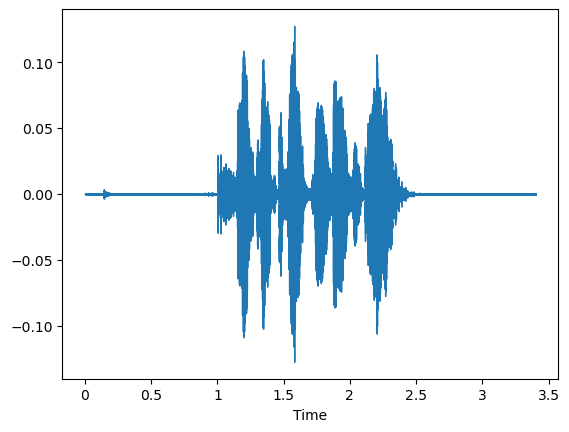

In [11]:
path_ = r"C:\Users\Admin\Documents\6TH SEMESTER\AAI_Project\audio_speech_actors_01-24\Actor_10\03-01-08-01-01-02-10.wav"
data_, sample_rate_ = librosa.load(path_)
librosa.display.waveshow(y=data_, sr=sample_rate_)
Audio(data_, rate=sample_rate_)

In [12]:
Features = pd.read_csv('features.csv')
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
#Re-creating model
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.load_weights('best_model_weights.h5')

In [14]:
sample_rate = 48000
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

X_ = np.array(extract_features(data_))
X_ = scaler.transform(X_.reshape(1,-1))
pred_test_ = model.predict(np.expand_dims(X_, axis=2))
y_pred_ = encoder.inverse_transform(pred_test_)

print("\nPredicted values for each emotion: ")
for value, emotion in zip(pred_test_[0], encoder.categories_[0]):
    print(emotion, f"{value:.10f}") 
    
print("\nPredicted emotion: " ,y_pred_[0][0]) 

1/1 [==============================] - 0s 330ms/step

Predicted values for each emotion: 
angry 0.0000026906
calm 0.0000000032
disgust 0.0001103712
fear 0.0064347936
happy 0.0000851657
neutral 0.0002175555
sad 0.0008887097
surprise 0.9922607541

Predicted emotion:  surprise
